### Imports

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from MALDI_class import MALDI, rawMALDI, binnedMALDI, selectedMALDI
from mass_functions import get_isotopes
from metaspace_class import metaspace
import os
import nibabel as nib
from sklearn.cluster import KMeans
import skimage.morphology as morph
from sklearn.decomposition import PCA


### Set file parameters

In [2]:
#raw_data_folder = '/data/datadata/40_MALDI/MALDI/'
raw_data_folder = '/data/pt_02040/MyelinQuantificationProject/raw_data/MALDI/'
#background_mask_folder = '/data/datadata/40_MALDI/MALDI/coregistration/'
background_mask_folder = '/data/pt_02040/MyelinQuantificationProject/coregistration/'

fullorselected = 'selected'#'full'

if fullorselected == 'selected':
    filename = 'sample_order_selected.csv'
    #results_folder = 'expdata/final/'
    results_folder = '/data/pt_02040/MyelinQuantificationProject/results_final/'
elif fullorselected == 'full':
    filename = 'sample_order_full.csv'
    #results_folder = 'expdata/final/full/'
    results_folder = '/data/pt_02040/MyelinQuantificationProject/results_final/full/'
else:
    raise ValueError('fullorselected needs to be selected or full')

if not os.path.isfile(results_folder + filename):
    raise ValueError('provide ' + filename + ' in results folder with sample names in raw_data_folder without imzML extension')
    
selected_samples = np.loadtxt(results_folder + 'sample_order_selected.csv', dtype = str)
all_samples = np.loadtxt(results_folder + 'sample_order_full.csv', dtype = str)
    
def path(folder, sample):
    base = folder + sample.split('_')[0] + '-' + sample.split('_')[1] + '/' + sample.split('_')[2] + '/RAW-Data/' + sample.split('_')[0] + '-' + sample.split('_')[1] + '_' + sample.split('_')[2] + '_pos'
    if os.path.isfile(base + '_validated' + '.imzML'):
        return base + '_validated' + '.imzML'
    elif os.path.isfile(base + '.imzML'):
        return base + '.imzML'
    else:
        raise ValueError('sample does not exist in folder under expected name pattern of\n' + base + '.imzML' + '\n or \n' + base + '_validated' + '.imzML')

print(selected_samples)

['brain201re_49_V1' 'brain201re_49_CoS' 'brain211re_27_V1'
 'brain211re_47_V1' 'brain211re_47_CoS' 'brain211re_49_CoS'
 'brain211re_37_MFS' 'brain211re_49_MFS' 'brain215re_27_V1'
 'brain215re_37_CoS' 'brain215re_47_MFS']


### Set MALDI data parameters

In [18]:
MALDI_parameters = {
	'resolution' : 18e-5,		#ppm
	'accuracy' : 2.5e-6,
    'global_range' : (400., 1000.),
	'normalize' : 'tic',
    'n_processes' : 1, 
    'n_clusters' : 3, 
    'include_ions' : False
}
MALDI_results = {
}

### Set METASPACE parameters

In [24]:
### Database parameters ###
metaspaceparams = {
	'databases' : ['HMDB', 'SwissLipids', 'LipidMaps'],
	'max_fdr' : .05,
    'api_key' : 'vxBtcaq839qX'
	}

### Matrix reference measurement parameters ###
matrixproject = 'b9195154-ba0d-11eb-96db-bbe19b6ae1a2'
matrixdataset = ['2021-05-21_10h24m13s', '2021-06-09_13h10m10s', '2021-07-02_15h25m26s']

### SAMPLE IDENTIFIERS FOR OLD, GREY NEW AND BRIGHT NEW DATA ###
project_id = '7b876960-ecbc-11ec-89bf-5b32557b3a87'
dataset_ids = ['2020-11-16_10h33m20s', '2020-11-16_11h12m42s', '2020-11-16_11h13m38s', '2020-11-16_11h15m09s', '2020-11-16_11h18m12s', '2020-11-16_11h21m21s', '2020-11-16_11h23m40s', '2022-04-22_13h50m55s', '2022-04-22_13h53m22s', '2022-04-22_13h43m51s', '2022-04-22_13h58m27s', '2022-04-22_13h57m25s', '2022-04-22_13h59m24s', '2022-04-22_14h00m05s']


### Get matrix annotations

In [5]:
matrix = metaspace(matrixdataset, databases = metaspaceparams['databases'], proj_id = matrixproject, api_key = metaspaceparams['api_key'])
matrix.get_datasets(drop_duplicates = False, sort_by = ['mz'])
matrixmzs = np.unique(matrix.data.mz.values)
#manually selected matrix ions
matrixions = ['C24H49NO3+H+', 'C27H46O4+Na+', 'C47H79NO8+Na+', 'C42H82NO11P+H+', 'C49H83NO8+Na+', 'C19H14O9+Na+', 'C10H15N5O9P2+H+', 'C24H40O4+Na+', 'C24H50NO7P+K+', 'C30H58NO10P+H+', 'C38H77NO4+Na+', 'C31H60NO10P+H+', 'C42H81NO3+H+', 'C32H62NO10P+H+', 'C40H81NO4+Na+', 'C41H83NO5+Na+', 'C37H71O8P+K+', 'C40H66O12+H+', 'C41H77O8P+K+', 'C43H76NO7P+Na+', 'C45H78NO7P+Na+', 'C42H81O10P+Na+', 'C45H80NO7P+Na+', 'C47H82NO7P+Na+', 'C46H90NO10P+H+', 'C47H93N2O6P+K+', 'C47H92NO8P+Na+', 'C46H90NO11P+H+', 'C48H94NO7P+K+', 'C20H36O2+H+', 'C20H43NO+H+', 'C21H36O5+Na+', 'C25H46O2+Na+', 'C23H47NO4+H+', 'C22H28O6+Na+', 'C30H50+Na+', 'C36H75N+H+', 'C26H54NO7P+H+', 'C40H81NO3+Na+', 'C42H81NO3+H+', 'C33H64NO9P+H+', 'C33H64NO10P+H+', 'C35H68NO9P+H+', 'C33H64NO10P+Na+', 'C35H68NO10P+Na+', 'C41H72O10+H+', 'C41H83N2O6P+H+', 'C23H34O5+H+', 'C27H44O2+H+', 'C26H38O4+H+', 'C37H70O12S+H+', 'C40H80NO8P+K+', 'C42H82NO8P+K+', 'C42H84NO8P+K+', 'C44H86NO8P+K+', 'C49H90NO8P+H+', 'C46H92NO11P+H+', 'C39H73O8P+K+', 'C45H74NO7P+H+']

### Get tissue annotations

In [6]:
mydataset = metaspace(dataset_ids, databases = metaspaceparams['databases'], proj_id = project_id, api_key = metaspaceparams['api_key'])

### Set filter parameters

In [7]:
filterparams = {
	'drop_duplicates' : False,
	'msm' : [.8],		#values for msm score threshold to evaluate
	'appearances' : [0],		#number of datasets a peak must appear in
	'force_dataset' : [None],		#datasets a peak must appear in at least on of
	'matrixmzs' : matrixmzs,		#List of matrix mz values to remove from the peaklist
	'matrixions' : matrixions,		#List of matrix ion names to remove from the peaklist
	'removerange' : 10e-6,
	'mzrange' : [400,1000]
}

### Filter annotations according to filterparameters and store the results in a csv table and overview figure

In [ ]:
name = results_folder + 'metaspacefiltering'
for msm in filterparams['msm']:
	for appearances in filterparams['appearances']:
		for force_dataset in filterparams['force_dataset']:
			print(appearances, msm, force_dataset)

			### GET DATASETS ###
			mydataset.get_datasets(drop_duplicates = filterparams['drop_duplicates'], sort_by = ['mz'])
			mydataset.data.sort_values(['mz'], inplace = True)

			### FILTER BY MSM ###
			mydataset.filter_by(parameters = ['msm'], values = [str(msm)], operators = ['>'])
			name += '_msm>' + str(msm)
			print('filter by msm>' + str(msm) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### FILTER BY APPEARANCE ###
			val, ind, counts = np.unique(mydataset.data.mz.values, return_index = True, return_counts = True)
			mydataset.data = mydataset.data[mydataset.data.mz.isin(val[counts>appearances])]
			name += '_appearance=' + str(appearances)
			print('filter by appearance=' + str(appearances) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### FILTER BY SINGLE DATASET ###
			if force_dataset is not None:
				mydataset.filter_by(parameters = ['dataset'], values = [str(force_dataset)], operators = ['=='])
				name += '_force_dataset=' + str(force_dataset)
				print('filter by force_dataset=' + str(force_dataset) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### DROP DUPLICATES ###
			mydataset.data.drop_duplicates(subset = ['ionFormula', 'ion'], inplace = True)		#remove resulting duplicates
			print('drop_duplicates' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### FILTER BY MATRIX MEASUREMENT ###
			if filterparams['matrixmzs'] is not None:
				mydataset.data = mydataset.data[~mydataset.data['mz'].isin(filterparams['matrixmzs'])]
				print('filter by matrixmzs' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
				mydataset.data = mydataset.data[~mydataset.data['ion'].isin(filterparams['matrixions'])]
				name += '_matrixmzs'
				print('filter by matrixmzs and matrixions' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### remove in 10ppm range ###
			if filterparams['removerange'] is not None:
				mydataset.filter_neighboring_mzs(rrange = filterparams['removerange'])
				name += '_removed' + str(filterparams['removerange'])
				print('filter by removerrange' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### FILTER BY mzrange ###
			mydataset.filter_by(parameters = ['mz'], values = [str(filterparams['mzrange'][0])], operators = ['>'])
			mydataset.filter_by(parameters = ['mz'], values = [str(filterparams['mzrange'][1])], operators = ['<'])
			name += '_mzrange>' + str(filterparams['mzrange'])
			print('filter by msm>' + str(filterparams['mzrange']) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### STORE DATA ###
			mydataset.data.insert(0, 'index', np.arange(1,mydataset.data.shape[0]+1))
			mydataset.data.to_csv(name + '.csv', columns = ['index', 'ionFormula', 'ion', 'mz', 'msm', 'rhoSpatial', 'rhoSpectral', 'moc', 'fdr', 'moleculeNames', 'moleculeGroups'])
			MALDI_results['selected_mzs'] = np.unique(mydataset.data.mz.values)
			if MALDI_parameters['include_ions']:
				MALDI_results['selected_ionformulas'] = np.unique(mydataset.data.ionFormula.values)
				MALDI_results['isotopes_dict'] = get_isotopes(MALDI_results['selected_ionformulas'], molecular_abundance_threshold = 5e-2)
			n_peaks = len(MALDI_results['selected_mzs'])

### Iterate through samples and process MALDI Data

In [26]:
MALDI_results['shape'] = []
MALDI_results['TIC'] = []
MALDI_results['center_of_mass'] = []
MALDI_results['mzmaps'] = []
MALDI_results['all_background_data'] = np.zeros((0,n_peaks))
MALDI_results['all_tissue_data'] = np.zeros((0,n_peaks))
MALDI_results['all_data'] = np.zeros((0,n_peaks))
for sample_index in range(len(all_samples)):
    print(all_samples[sample_index])
    ### LOAD DATA ###
    M = MALDI(path(raw_data_folder, all_samples[sample_index]), resolution = MALDI_parameters['resolution'], n_processes = MALDI_parameters['n_processes'])
    ### GET RAW DATA ###
    M_raw = rawMALDI(M.filename, M.resolution, M.range_, M.n_processes)
    print('mass range', M_raw.range_)
    MALDI_results['shape'].append(M_raw.shape)
    ### NORMALIZE DATA ###
    MALDI_results['TIC'].append(M_raw.normalize(algorithm = MALDI_parameters['normalize'], return_map = True))
    ### CALCULATE CENTER OF MASS ###
    MALDI_results['center_of_mass'].append(M_raw.center_of_mass(massrange = (550,900)))
    ### CALCULATE MZ MAPS ###
    imgstack = np.zeros((M.shape[0], M.shape[1], n_peaks))
    if MALDI_parameters['include_ions']:
        for peak in range(n_peaks):
            isotopes = []
            for isotope in MALDI_results['isotopes_dict'][MALDI_results['selected_ionformulas'][peak]]:
                mz, abundance, relative_abundance = MALDI_results['isotopes_dict'][MALDI_results['selected_ionformulas'][peak]][isotope]
                isotopes.append(M_raw.massvec(mz)*abundance)
            imgstack[:,:,peak] = M_raw.get_2D(np.sum(isotopes, axis = 0))
    else:
        for peak in range(n_peaks):
            imgstack[:,:,peak] = M_raw.get_2D(M_raw.massvec(MALDI_results['selected_mzs'][peak]))
    MALDI_results['mzmaps'].append(imgstack)
    ### LOAD INITIAL BACKGROUND MASKS ###
    mask = nib.load(background_mask_folder + all_samples[sample_index].split('_')[0] + '/inputs/' + 'MALDI_' + all_samples[sample_index].split('_')[0] + '_' + all_samples[sample_index].split('_')[1] + '_' + all_samples[sample_index].split('_')[2] + '_background_mask.nii.gz').get_fdata()
    MALDI_results['all_background_data'] = np.append(MALDI_results['all_background_data'], imgstack[mask[:,:,0]!=0, :], axis = 0)
    MALDI_results['all_tissue_data'] = np.append(MALDI_results['all_tissue_data'], imgstack[mask[:,:,0]==0, :], axis = 0)
    MALDI_results['all_data'] = np.append(MALDI_results['all_data'], imgstack.reshape(M.shape[0]*M.shape[1], n_peaks), axis = 0)
    
    

brain201re_49_V1
number of pixels 5229
image shape [63 83]
mass range (300.0013371474396, 1001.5039132578256)
brain201re_49_CoS
number of pixels 5248
image shape [64 82]
mass range (350.0014286517167, 1001.5038944984896)
brain201re_49_MFS
number of pixels 6328
image shape [ 56 113]
mass range (350.00188104179546, 1001.5037819005396)
brain211re_27_V1
number of pixels 10712
image shape [103 104]
mass range (400.0015563964844, 1001.5037841796875)
brain211re_47_V1
number of pixels 3904
image shape [64 61]
mass range (400.0038146972656, 1001.5071411132812)
brain211re_49_V1
number of pixels 15555
image shape [ 85 183]
mass range (300.00153778879195, 1001.5039132578256)
brain211re_47_CoS
number of pixels 5135
image shape [79 65]
mass range (400.0041809082031, 1001.5071411132812)
brain211re_49_CoS
number of pixels 5170
image shape [55 94]
mass range (350.00179567455325, 1001.5040121075231)
brain211re_37_MFS
number of pixels 9605
image shape [ 85 113]
mass range (400.0021057128906, 1001.5071411

### Calculate mask

In [28]:
background_init_cluster = np.mean(MALDI_results['all_background_data'], axis = 0)
tissue_init_cluster = KMeans(random_state = 1234, n_clusters =  MALDI_parameters['n_clusters']-1).fit(MALDI_results['all_tissue_data'])
full_init_cluster = np.append(background_init_cluster, tissue_init_cluster.cluster_centers_).reshape(MALDI_parameters['n_clusters'], n_peaks)
final_cluster = KMeans(random_state = 1234, n_clusters =  MALDI_parameters['n_clusters'], init = full_init_cluster).fit(MALDI_results['all_data'])




/data/hu_sjung/.local/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning:

Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.



In [29]:
MALDI_results['cluster_maps'] = []
for sample_index in range(len(all_samples)):
    print(all_samples[sample_index])
    mask = nib.load(background_mask_folder + all_samples[sample_index].split('_')[0] + '/inputs/' + 'MALDI_' + all_samples[sample_index].split('_')[0] + '_' + all_samples[sample_index].split('_')[1] + '_' + all_samples[sample_index].split('_')[2] + '_background_mask.nii.gz').get_fdata()
    image = final_cluster.predict(MALDI_results['mzmaps'][sample_index].reshape(np.prod(MALDI_results['shape'][sample_index]), n_peaks)).reshape(MALDI_results['shape'][sample_index])
    opened = morph.area_opening(image, 4)
    cluster_map = morph.area_closing(opened, 4)
    cluster_map[mask[:,:,0]!=0] = 0
    ### MAPPING ###
    cluster_map[cluster_map == 2] = 3
    cluster_map[cluster_map == 1] = 2
    cluster_map[cluster_map == 3] = 1
    MALDI_results['cluster_maps'].append(cluster_map)
    

### Get region spectra and calculate PCA

In [32]:
MALDI_results['mean_spectrum'] = []
MALDI_results['mean_white_matter_spectrum'] = []
MALDI_results['mean_cortex_spectrum'] = []
MALDI_results['masked_mzmaps'] = []
MALDI_results['standardized_masked_mzmaps'] = []
MALDI_results['mean_img'] = []
MALDI_results['pca'] = []
MALDI_results['bins'] = []
MALDI_results['bincenters'] = []
for sample_index in range(len(all_samples)):
    print(all_samples[sample_index])
    ### LOAD DATA ###
    M = MALDI(path(raw_data_folder, all_samples[sample_index]), resolution = MALDI_parameters['resolution'], n_processes = MALDI_parameters['n_processes'], range_ = MALDI_parameters['global_range'])
    ### GET RAW DATA ###
    M_raw = rawMALDI(M.filename, M.resolution, M.range_, M.n_processes)
    ### NORMALIZE DATA ###
    M_raw.normalize(algorithm = MALDI_parameters['normalize'])
    ### CALCULATE BINNED DATA ###
    M_binned = binnedMALDI(M.filename, M.resolution, M.range_, M.n_processes, data_spectrum = M_raw.data_spectrum)
    MALDI_results['bins'].append(M_binned.bins)
    MALDI_results['bincenters'].append(M_binned.bincenters)
    ### CALCULATE MEAN SPECTRA for full measurement and tissue regions ###
    MALDI_results['mean_spectrum'].append(np.mean(M_binned.data_histo, axis = 0))
    MALDI_results['mean_cortex_spectrum'].append(np.mean(M_binned.data_histo[MALDI_results['cluster_maps'][sample_index][M.map2D[:,0], M.map2D[:,1]] == 1], axis = 0))
    MALDI_results['mean_white_matter_spectrum'].append(np.mean(M_binned.data_histo[MALDI_results['cluster_maps'][sample_index][M.map2D[:,0], M.map2D[:,1]] == 2], axis = 0))
  
    ### MASK BACKGROUND ###
    MALDI_results['masked_mzmaps'].append(np.copy(MALDI_results['mzmaps'][sample_index]))
    MALDI_results['masked_mzmaps'][sample_index][MALDI_results['cluster_maps'][sample_index] == 0, :] = None
    MALDI_results['masked_mzmaps'][sample_index] = MALDI_results['masked_mzmaps'][sample_index].reshape(np.prod(MALDI_results['shape'][sample_index]), n_peaks)
    ### MEAN IMAGE OF PEAKMAPS ###
    MALDI_results['mean_img'].append(np.sum(MALDI_results['masked_mzmaps'][sample_index], axis = 1))    
    ### STANDARDIZE PEAKMAPS ###
    MALDI_results['standardized_masked_mzmaps'].append((MALDI_results['masked_mzmaps'][sample_index] - np.nanmean(MALDI_results['masked_mzmaps'][sample_index], axis = 0)) / np.nanstd(MALDI_results['masked_mzmaps'][sample_index], axis = 0))

    ### CALCULATE PCA ###
    MALDI_results['pca'].append(PCA(n_components = n_peaks).fit(MALDI_results['standardized_masked_mzmaps'][sample_index][MALDI_results['cluster_maps'][sample_index].reshape(np.prod(MALDI_results['shape'][sample_index])) != 0, :]))
    

    
    

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Upda

### Print and store

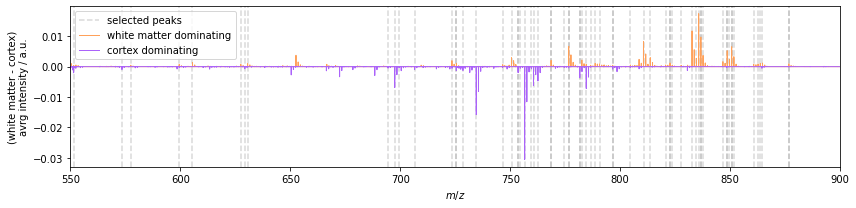

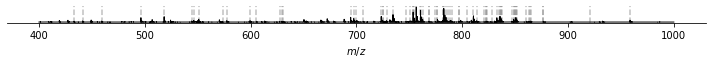

brain201re_49_V1


/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Upda

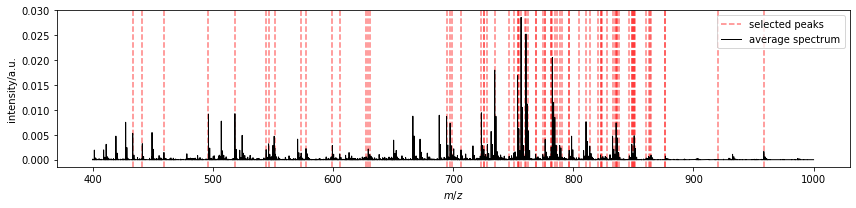

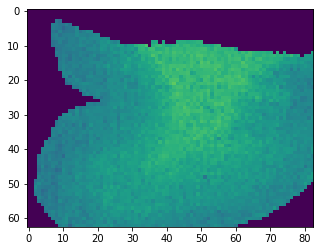

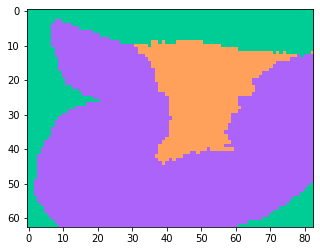

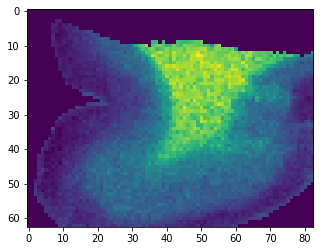

brain201re_49_CoS


/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Upda

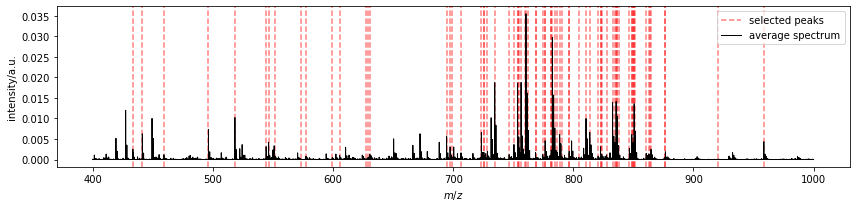

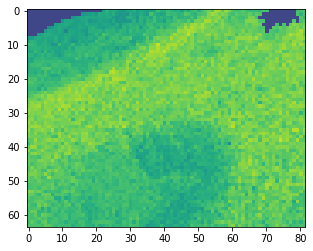

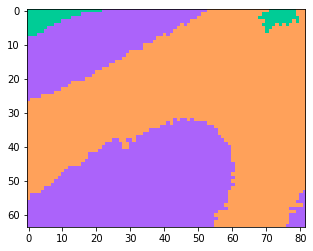

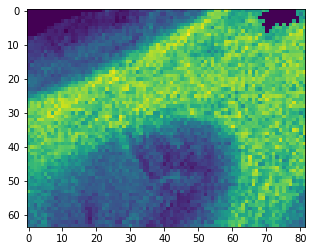

brain201re_49_MFS


/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Upda

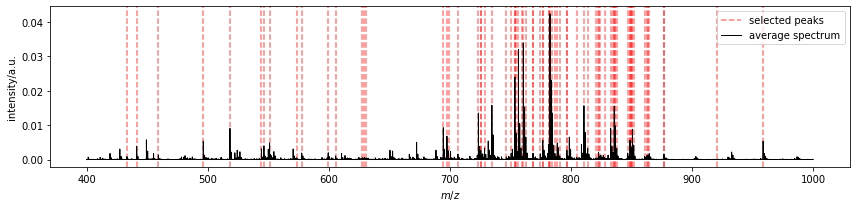

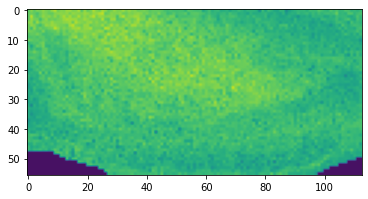

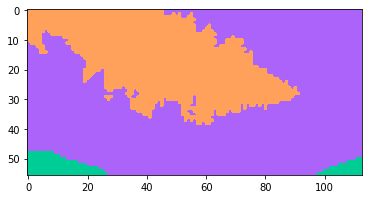

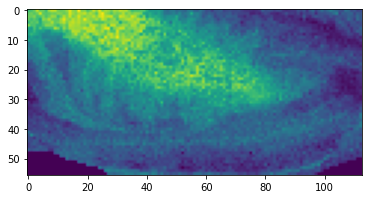

brain211re_27_V1


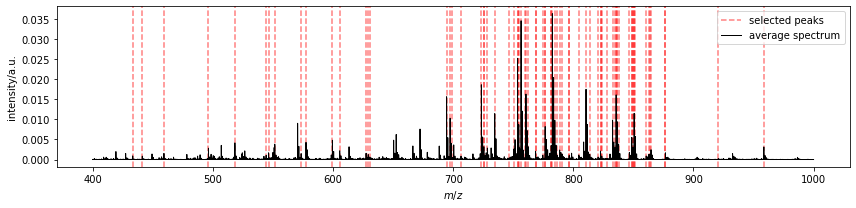

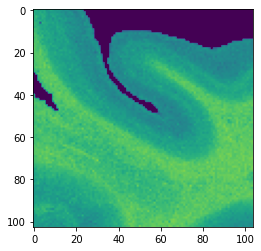

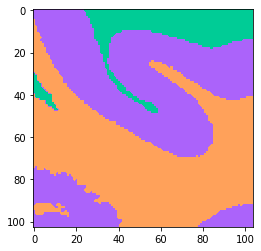

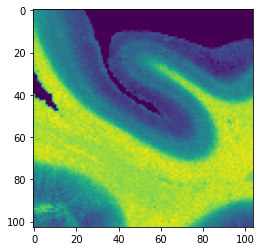

brain211re_47_V1


/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Upda

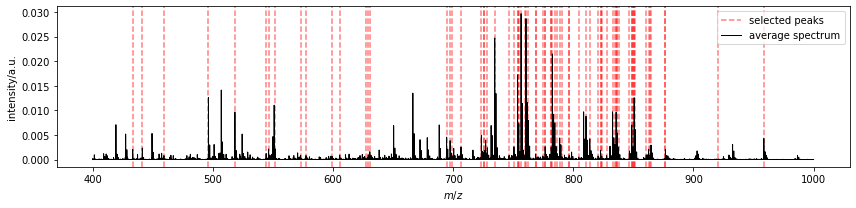

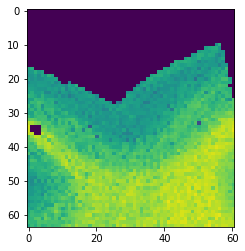

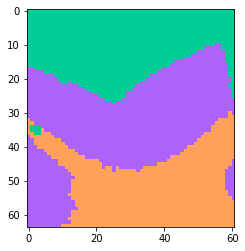

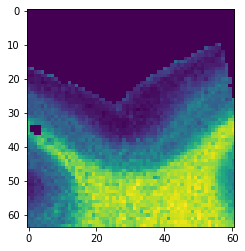

brain211re_49_V1


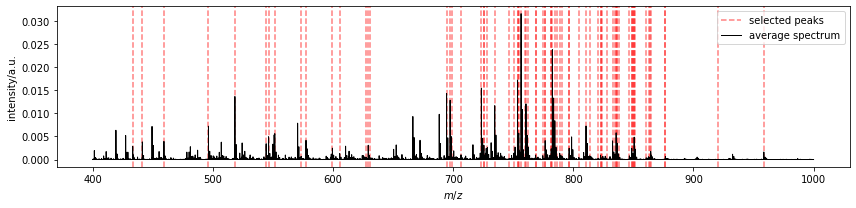

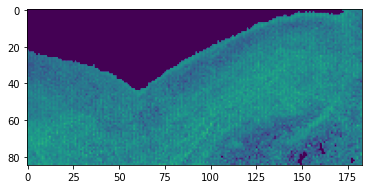

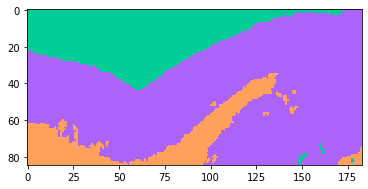

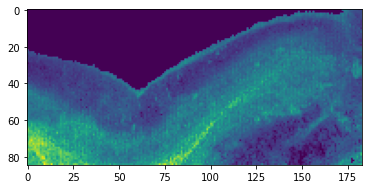

brain211re_47_CoS


/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Upda

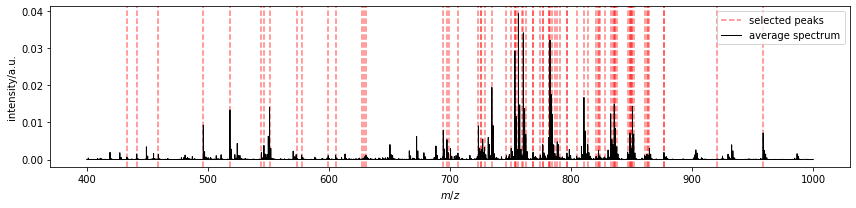

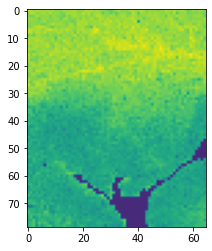

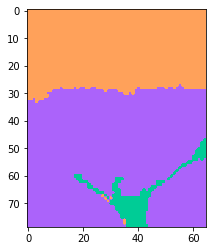

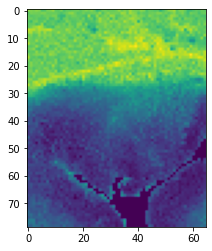

brain211re_49_CoS


/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Upda

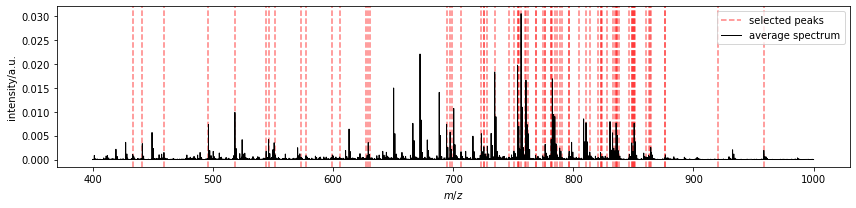

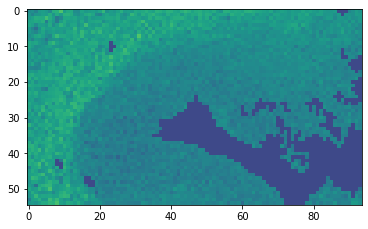

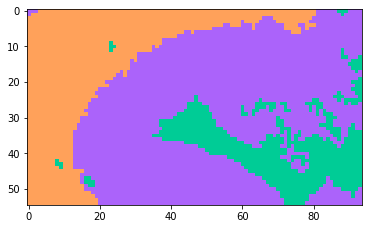

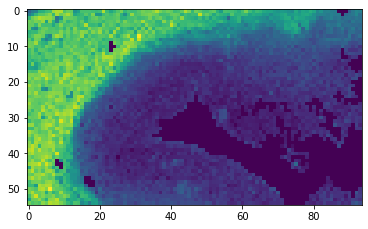

brain211re_37_MFS


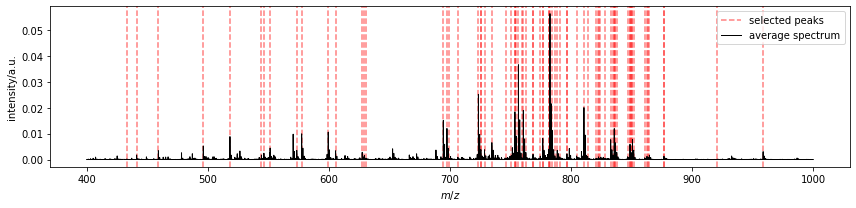

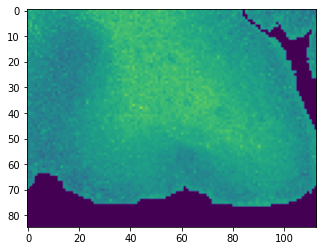

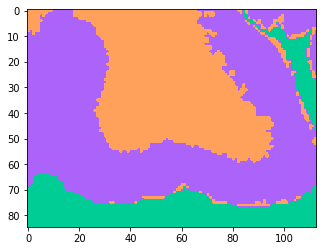

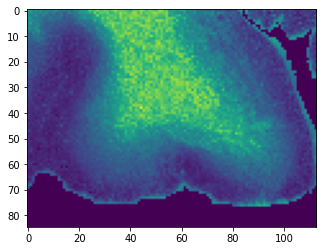

brain211re_49_MFS


/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".

/data/hu_sjung/.local/lib/python3.6/site-packages/pyimzml/ontology/ontology.py:88: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Upda

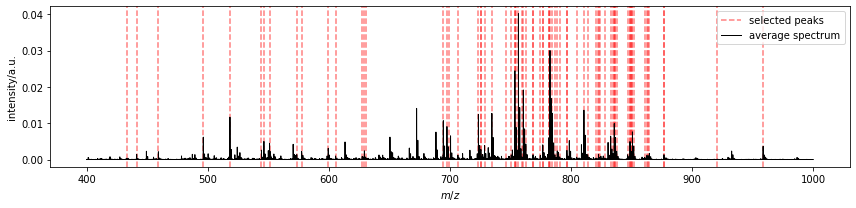

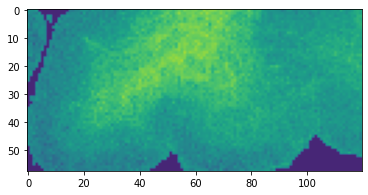

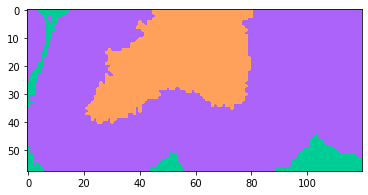

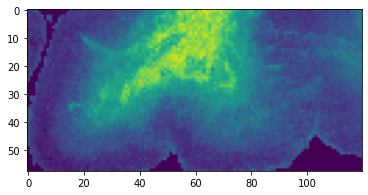

brain215re_27_V1


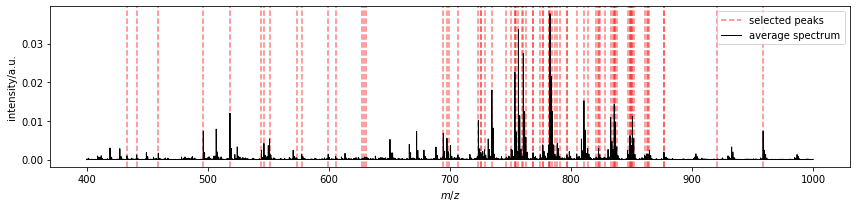

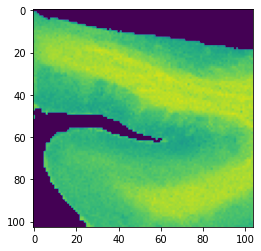

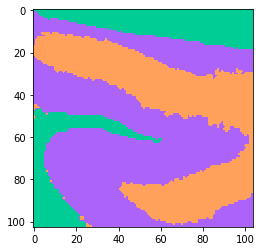

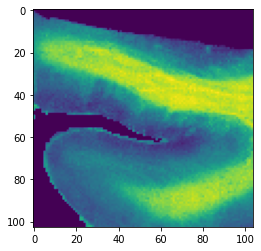

brain215re_39_V1


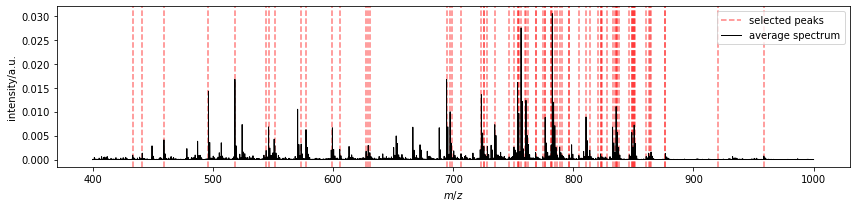

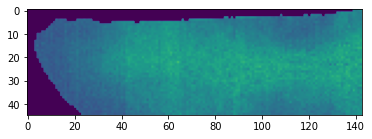

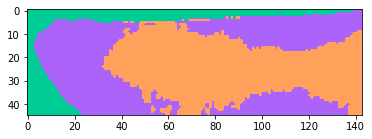

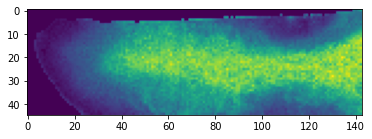

brain215re_37_CoS


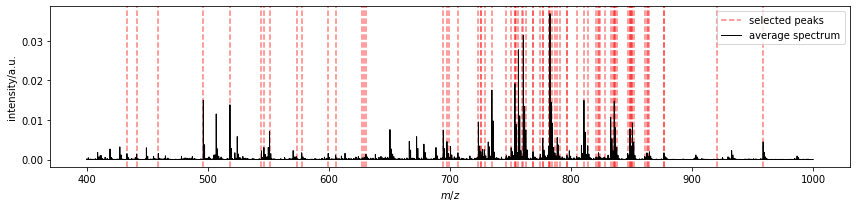

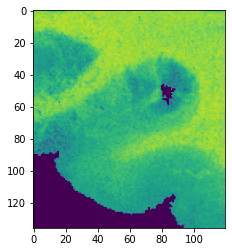

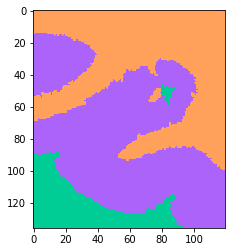

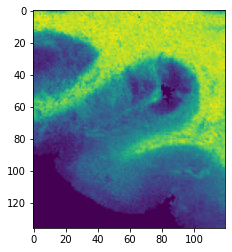

brain215re_47_MFS


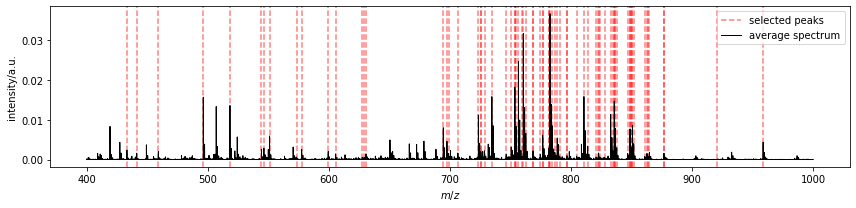

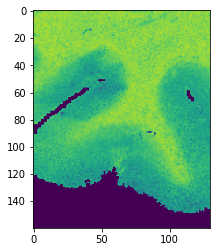

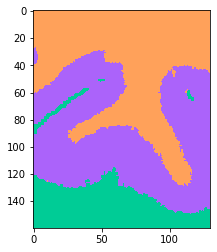

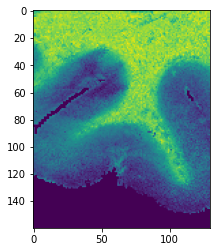

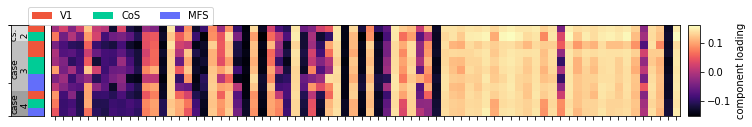

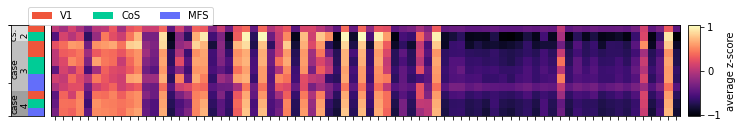

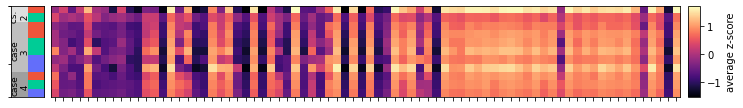

In [33]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import plotly

colors = plotly.colors.qualitative.Plotly
cluster_colors = [colors[2], colors[3], colors[4]]#['#0072BD', '#D95319', '#EDB120']
cluster_cmap = ListedColormap(cluster_colors)
region_colors = [colors[1], colors[2], colors[0]]#['#C00000', '#2D932D', '#0070C0']
region_cmap = ListedColormap(region_colors)
brain_cmap = ListedColormap(['#00000020', '#00000040', '#00000060'])
center_of_mass_limits = (680, 790)

if not os.path.isdir(results_folder + 'peakmaps/'):
    os.mkdir(results_folder + 'peakmaps/')
if not os.path.isdir(results_folder + 'pca/'):
    os.mkdir(results_folder + 'pca/')

allcoeffs = np.zeros((len(selected_samples), n_peaks))
mean_cortex_scores = np.zeros((len(selected_samples), n_peaks))
mean_white_matter_scores = np.zeros((len(selected_samples), n_peaks))

legend_plot = np.zeros((len(selected_samples),3))
legend_encoding = {}
legend_encoding['brain201re'] = 0
legend_encoding['brain211re'] = 1
legend_encoding['brain215re'] = 2
legend_encoding['V1'] = 0
legend_encoding['CoS'] = 1
legend_encoding['MFS'] = 2
regions = ['V1', 'CoS', 'MFS']

### PLOT REGION DIFFERENCE IN MASS DISTRIBUTION ###
plt.figure(figsize = (12,3))
diffs = np.mean(MALDI_results['mean_white_matter_spectrum'], axis = 0)-np.mean(MALDI_results['mean_cortex_spectrum'], axis = 0)
for peak in MALDI_results['selected_mzs'][:-1]:
    plt.axvline(peak, linestyle = '--', color = 'grey', alpha = .3)
plt.axvline(MALDI_results['selected_mzs'][-1], linestyle = '--', color = 'grey', label = 'selected peaks', alpha = .3)
plt.plot(MALDI_results['bincenters'][0][diffs>0], diffs[diffs>0], linewidth = 1., color = cluster_colors[2], label = 'white matter dominating')
plt.plot(MALDI_results['bincenters'][0][diffs<0], diffs[diffs<0], linewidth = 1., color = cluster_colors[1], label = 'cortex dominating')
plt.xlabel('$m/z$')
plt.ylabel('(white matter - cortex)\navrg intensity / a.u.')
plt.xlim((550, 900))
plt.legend(loc = 'best')
plt.tight_layout()
plt.savefig(results_folder + 'white-greyspec' + '_.png', transparent = True)
plt.show()

### PLOT MEAN MEAN SPECTRUM ###
mean = np.mean(MALDI_results['mean_spectrum'], axis = 0)
plt.figure(figsize = (10,1))
for peak in MALDI_results['selected_mzs'][:-1]:
    plt.axvline(peak, linestyle = '--', color = 'gray', alpha = .5)
plt.axvline(MALDI_results['selected_mzs'][-1], linestyle = '--', color = 'gray', label = 'selected peaks', alpha = .5)
plt.plot(MALDI_results['bincenters'][sample_index], mean, linewidth = 1., color = 'k', label = 'average spectrum')
plt.xlabel('$m/z$')
#plt.ylabel('intensity/a.u.')
#plt.legend(loc = 'best')
plt.tick_params(left=False, labelleft=False)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(results_folder + 'meanmeanspec.png', transparent = True, dpi = 1000)
plt.show()
for sample_index in range(len(all_samples)):
    print(all_samples[sample_index])
    M = MALDI(path(raw_data_folder, all_samples[sample_index]), resolution = MALDI_parameters['resolution'], n_processes = MALDI_parameters['n_processes'], range_ = MALDI_parameters['global_range'])

    background = MALDI_results['cluster_maps'][sample_index] == 0
    tissue = MALDI_results['cluster_maps'][sample_index] != 0    
    flattened_tissue = MALDI_results['cluster_maps'][sample_index].reshape(np.prod(MALDI_results['shape'][sample_index])) != 0
    
    ### PLOT MEAN SPECTRUM ###
    plt.figure(figsize = (12,3))
    for peak in MALDI_results['selected_mzs'][:-1]:
        plt.axvline(peak, linestyle = '--', color = 'r', alpha = .5)
    plt.axvline(MALDI_results['selected_mzs'][-1], linestyle = '--', color = 'r', label = 'selected peaks', alpha = .5)
    plt.plot(MALDI_results['bincenters'][sample_index], MALDI_results['mean_spectrum'][sample_index], linewidth = 1., color = 'k', label = 'average spectrum')
    plt.xlabel('$m/z$')
    plt.ylabel('intensity/a.u.')
    plt.legend(loc = 'best')
    plt.tight_layout()
    plt.savefig(results_folder + all_samples[sample_index] + '_meanspec.png', transparent = True)
    plt.show()    
    
    ### PLOT TOTAL ION CURRENT MAP ###
    TIC_image = np.log(M.get_2D(MALDI_results['TIC'][sample_index]/np.mean(MALDI_results['TIC'][sample_index])))
    TIC_image[background] = 0
    plt.imsave(results_folder + all_samples[sample_index] + '_TIC.png', TIC_image, vmin =np.log(1/5), vmax =np.log(1*5), cmap = 'coolwarm')

    ### PLOT CENTER OF MASS MAP ###
    min_ = np.nanmin(MALDI_results['center_of_mass'][sample_index])
    com_image = M.get_2D(MALDI_results['center_of_mass'][sample_index])
    com_image[background] = min_
    plt.imsave(results_folder + all_samples[sample_index] + '_center_of_mass.png', com_image, vmin = center_of_mass_limits[0], vmax = center_of_mass_limits[1])
    plt.imshow(com_image, vmin = center_of_mass_limits[0], vmax = center_of_mass_limits[1])
    plt.show()

    ### PLOT AND STORE SELECTED PEAK MAPS ###
    for peak in range(n_peaks):
        img = MALDI_results['masked_mzmaps'][sample_index][:,peak].reshape(MALDI_results['shape'][sample_index])
        img_standardized = MALDI_results['standardized_masked_mzmaps'][sample_index][:,peak].reshape(MALDI_results['shape'][sample_index])
        img[np.isnan(img)] = np.min([0,np.nanmin(img)])
        img_standardized[np.isnan(img_standardized)] = np.min([0,np.nanmin(img_standardized)])
        plt.imsave(results_folder + 'peakmaps/' + all_samples[sample_index] + '_mz' + str(peak+1).zfill(2) + '_view.png', img)
        plt.imsave(results_folder + 'peakmaps/' + all_samples[sample_index] + '_mz' + str(peak+1).zfill(2) + '_view_standardized.png', img_standardized)
        np.savetxt(results_folder + 'peakmaps/' + all_samples[sample_index] + '_mz' + str(peak+1).zfill(2) + '_map.csv', img, delimiter = ',')
        np.savetxt(results_folder + 'peakmaps/' + all_samples[sample_index] + '_mz' + str(peak+1).zfill(2) + '_map_standardized.csv', img_standardized, delimiter = ',')
    
    ### PLOT AND STORE MASK MAP ###
    plt.imsave(results_folder + all_samples[sample_index] + '_mask.png', MALDI_results['cluster_maps'][sample_index], cmap = cluster_cmap)
    np.savetxt(results_folder + all_samples[sample_index] + '_mask.csv', MALDI_results['cluster_maps'][sample_index], delimiter = ',')
    plt.imshow(MALDI_results['cluster_maps'][sample_index], cmap = cluster_cmap)
    plt.show()
    
    ### PLOT AND STORE 1st AND 2nd PCA COMPONENTS AND EXPLAINED VAIANCE ###
    results = np.zeros((np.prod(MALDI_results['shape'][sample_index]), n_peaks))
    results[flattened_tissue,:] = MALDI_results['pca'][sample_index].transform(MALDI_results['standardized_masked_mzmaps'][sample_index][flattened_tissue])

    if np.corrcoef(results[flattened_tissue,0], MALDI_results['cluster_maps'][sample_index][tissue])[0,1] < 0:
        components0 = -1*MALDI_results['pca'][sample_index].components_[0,:]
        pcamap0 = -1*results[:,0].reshape(MALDI_results['shape'][sample_index])
    else:
        components0 = MALDI_results['pca'][sample_index].components_[0,:]
        pcamap0 = results[:,0].reshape(MALDI_results['shape'][sample_index])
    components1 = MALDI_results['pca'][sample_index].components_[1,:]
    pcamap1 = results[:,1].reshape(MALDI_results['shape'][sample_index])

    min_ = np.nanmin(pcamap0)
    pcamap0[background] = min_
    min_ = np.nanmin(pcamap1)
    pcamap1[background] = min_
    ev = MALDI_results['pca'][sample_index].explained_variance_
    
    plt.imsave(results_folder + 'pca/' + all_samples[sample_index] + '_map1.png', pcamap0)
    plt.imsave(results_folder + 'pca/' + all_samples[sample_index] + '_map2.png', pcamap1)
    np.savetxt(results_folder + 'pca/' + all_samples[sample_index] + '_map1.csv', pcamap0, delimiter = ',')
    np.savetxt(results_folder + 'pca/' + all_samples[sample_index] + '_components1.csv', components0, delimiter = ',')
    np.savetxt(results_folder + 'pca/' + all_samples[sample_index] + '_map2.csv', pcamap1, delimiter = ',')
    np.savetxt(results_folder + 'pca/' + all_samples[sample_index] + '_components2.csv', components1, delimiter = ',')
    np.savetxt(results_folder + 'pca/' + all_samples[sample_index] + '_ev.csv', ev, delimiter = ',')
    plt.imshow(pcamap0)
    plt.show()
    
    ### MAKE HEATMAP LEGEND ENCODING ###
    if all_samples[sample_index] in selected_samples:
        selected_sample_index = np.where(selected_samples == all_samples[sample_index])[0][0]
        legend_plot[selected_sample_index,0] = legend_encoding[selected_samples[selected_sample_index].split('_')[0]]
        legend_plot[selected_sample_index,2] = legend_encoding[selected_samples[selected_sample_index].split('_')[2]]

        ### MAP PCA COEFFEICIENTS AND AVERAGE REGIONAL SCORES THROUGHOUT selected_samples AND SELECTED PEAKS ###
        allcoeffs[selected_sample_index,:] = components0
        mean_cortex_scores[selected_sample_index,:] = np.mean(MALDI_results['standardized_masked_mzmaps'][sample_index][MALDI_results['cluster_maps'][sample_index].reshape(np.prod(MALDI_results['shape'][sample_index])) == 1], axis = 0)
        mean_white_matter_scores[selected_sample_index,:] = np.mean(MALDI_results['standardized_masked_mzmaps'][sample_index][MALDI_results['cluster_maps'][sample_index].reshape(np.prod(MALDI_results['shape'][sample_index])) == 2], axis = 0)

    

brain_plot = np.copy(legend_plot)
brain_plot[:,1:] = None
region_plot = np.copy(legend_plot)
region_plot[:,:2] = None

### PLOT PCA HEATMAP ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,3))
divider = HBoxDivider(fig, 111, horizontal=[Size.AxesX(ax1), Size.Fixed(0.1), Size.AxesX(ax2)], vertical=[Size.AxesY(ax1), Size.Scaled(1), Size.AxesY(ax2)])
ax1.set_axes_locator(divider.new_locator(0))
ax2.set_axes_locator(divider.new_locator(2))
ax1.imshow(brain_plot, cmap = brain_cmap, extent = [0,6,0,len(selected_samples)])
ax1.imshow(region_plot[:,1:], cmap = region_cmap, extent = [0,4,0,len(selected_samples)])
ax1.set_yticks([len(selected_samples),11,4,0])#np.arange(len(ylabels)))
ax1.set_yticklabels(['', '', '', ''])#ylabels)
ax1.text(-0.06,.5, 'case\n  4', fontsize = 9, rotation=90)
ax1.text(-0.06,4.8, 'case\n  3', fontsize = 9, rotation=90)
ax1.text(-0.06,9, ' cs.\n  2', fontsize = 9, rotation=90)
ax1.set_xticks([])
ax1.set_xticklabels([])
im = ax2.imshow(allcoeffs, cmap = 'magma')
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.set_xticks(np.arange(n_peaks))
ax2.set_xticklabels([])
axins = inset_axes(ax2, height="100%", width="2%", loc='center right', borderpad=-2)
plt.colorbar(im, label = 'component loading', cax = axins)
ax2.bar(np.arange(3)+80, np.ones(3), color = region_colors[0], label = regions[0])
ax2.bar(np.arange(3)+80, np.ones(3), color = region_colors[1], label = regions[1])
ax2.bar(np.arange(3)+80, np.ones(3), color = region_colors[2], label = regions[2])
ax2.set_xlim(-.5,n_peaks-.5)
ax2.legend(ncol=3, loc='center', bbox_to_anchor=(0.11, 1.1))#(0.147, 1.1))#, handletextpad=.7, handlelength = .005, fontsize = 8)
plt.savefig(results_folder + 'pca/' + 'pca_score.png', dpi = 1000, transparent = True)
plt.show()

### PLOT CORTEX HEATMAP ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,3))
divider = HBoxDivider(fig, 111, horizontal=[Size.AxesX(ax1), Size.Fixed(0.1), Size.AxesX(ax2)], vertical=[Size.AxesY(ax1), Size.Scaled(1), Size.AxesY(ax2)])
ax1.set_axes_locator(divider.new_locator(0))
ax2.set_axes_locator(divider.new_locator(2))
ax1.imshow(brain_plot, cmap = brain_cmap, extent = [0,6,0,len(selected_samples)])
ax1.imshow(region_plot[:,1:], cmap = region_cmap, extent = [0,4,0,len(selected_samples)])
ax1.set_yticks([len(selected_samples),11,4,0])#np.arange(len(ylabels)))
ax1.set_yticklabels(['', '', '', ''])#ylabels)
ax1.text(-0.06,.5, 'case\n  4', fontsize = 9, rotation=90)
ax1.text(-0.06,4.8, 'case\n  3', fontsize = 9, rotation=90)
ax1.text(-0.06,9, ' cs.\n  2', fontsize = 9, rotation=90)
ax1.set_xticks([])
ax1.set_xticklabels([])
im = ax2.imshow(mean_cortex_scores, cmap = 'magma')
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.set_xticks(np.arange(n_peaks))
ax2.set_xticklabels([])
axins = inset_axes(ax2, height="100%", width="2%", loc='center right', borderpad=-2)
plt.colorbar(im, label = 'average z-score', cax = axins)
ax2.bar(np.arange(3)+80, np.ones(3), color = region_colors[0], label = regions[0])
ax2.bar(np.arange(3)+80, np.ones(3), color = region_colors[1], label = regions[1])
ax2.bar(np.arange(3)+80, np.ones(3), color = region_colors[2], label = regions[2])
ax2.set_xlim(-.5,n_peaks-.5)
ax2.legend(ncol=3, loc='center', bbox_to_anchor=(0.11, 1.1))#(0.147, 1.1))#, handletextpad=.7, handlelength = .005, fontsize = 8)
plt.savefig(results_folder + 'pca/' + 'cortex_score.png', dpi = 1000, transparent = True)
plt.show()

### PLOT WHITE MATTER HEATMAP ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,3))
divider = HBoxDivider(fig, 111, horizontal=[Size.AxesX(ax1), Size.Fixed(0.1), Size.AxesX(ax2)], vertical=[Size.AxesY(ax1), Size.Scaled(1), Size.AxesY(ax2)])
ax1.set_axes_locator(divider.new_locator(0))
ax2.set_axes_locator(divider.new_locator(2))
ax1.imshow(brain_plot, cmap = brain_cmap, extent = [0,6,0,len(selected_samples)])
ax1.imshow(region_plot[:,1:], cmap = region_cmap, extent = [0,4,0,len(selected_samples)])
ax1.set_yticks([len(selected_samples),11,4,0])#np.arange(len(ylabels)))
ax1.set_yticklabels(['', '', '', ''])#ylabels)
ax1.text(-0.06,.5, 'case\n  4', fontsize = 9, rotation=90)
ax1.text(-0.06,4.8, 'case\n  3', fontsize = 9, rotation=90)
ax1.text(-0.06,9, ' cs.\n  2', fontsize = 9, rotation=90)
ax1.set_xticks([])
ax1.set_xticklabels([])
im = ax2.imshow(mean_white_matter_scores, cmap = 'magma')
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.set_xticks(np.arange(n_peaks))
ax2.set_xticklabels([])
axins = inset_axes(ax2, height="100%", width="2%", loc='center right', borderpad=-2)
plt.colorbar(im, label = 'average z-score', cax = axins)
ax2.bar(np.arange(3)+80, np.ones(3), color = region_colors[0], label = regions[0])
ax2.bar(np.arange(3)+80, np.ones(3), color = region_colors[1], label = regions[1])
ax2.bar(np.arange(3)+80, np.ones(3), color = region_colors[2], label = regions[2])
ax2.set_xlim(-.5,n_peaks-.5)
#ax2.legend(ncol=3, loc='center', bbox_to_anchor=(0.11, 1.1))#(0.147, 1.1))#, handletextpad=.7, handlelength = .005, fontsize = 8)
plt.savefig(results_folder + 'pca/' + 'white_matter_score.png', dpi = 1000, transparent = True)
plt.show()
    
### STORE GENERAL DICTS ###
np.save(results_folder + 'MALDI_results.npy', MALDI_results)
np.save(results_folder + 'MALDI_parameters.npy', MALDI_parameters)